In [41]:
import cv2 as cv
import numpy as np
import random
from PIL import Image
from image_utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
st = np.load('nums/sixteen.npy')

In [148]:
st = (adaptive_thresh(st))

In [150]:
def display(img):
    return Image.fromarray(img)

In [213]:
a = get_blanks('blanks')[0]
a.img = adaptive_thresh(a.img)

cnt = 0

while cnt < 5:
    row = random.randint(a.min_row, a.max_row)
    col = random.randint(a.min_col, a.max_col)
    
    while not a.place_object(st, (row, col)):
        continue
    
    cnt += 1


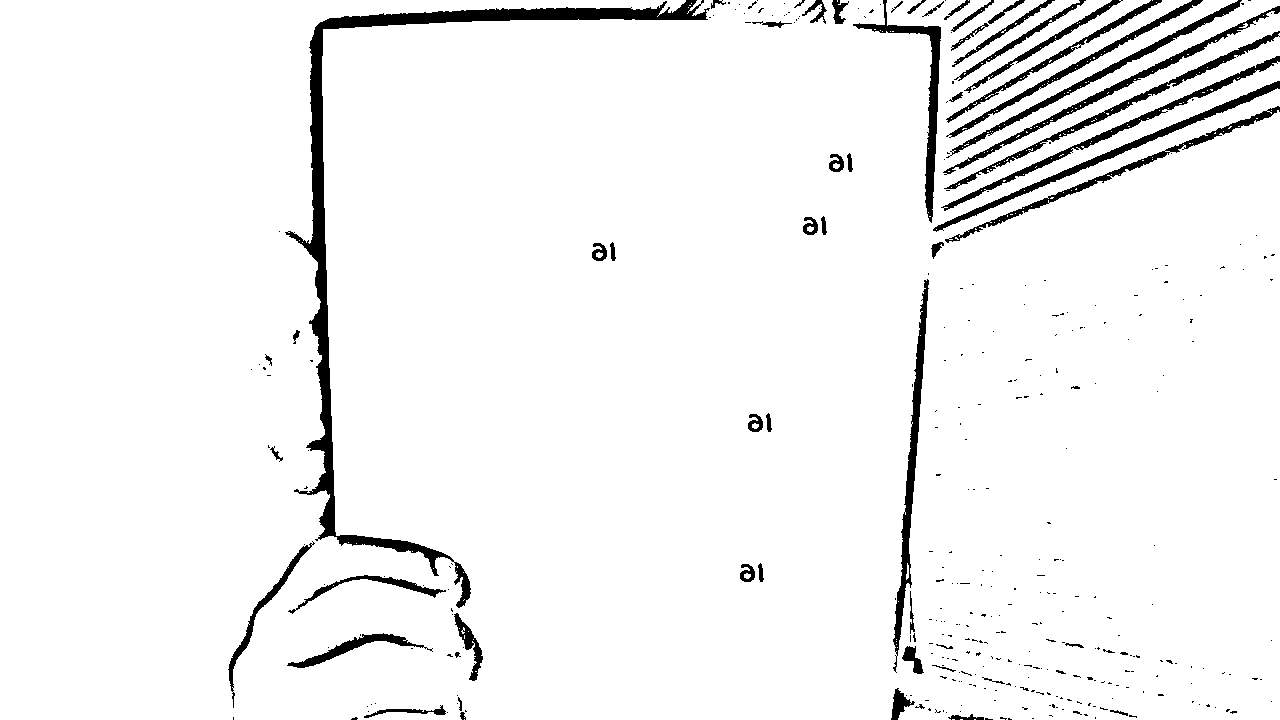

In [214]:
display(adaptive_thresh(a.img))